In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

In [60]:
######################################
# Hyper-parameters (entered by user) #
######################################


PRI = 5  # usec
Pw = 2  # usec
CPI = 0.5  # msec
B = 100  # MHz
fc = 40  # GHz
intervals = 2000  # num of time intervals for a single PRI
R0 = np.array([400], dtype=complex)  # initial range of target in m
v = np.array([100], dtype=complex)  # speed of target in m/sec
sigma = np.array([1], dtype=complex)  # amplitude for targets
AWGN_sigma = 0  # std of white noise


######################################################################
# Automatically defined constants and timimg samples (do not change) #
######################################################################


# scaling and constants
PRI = PRI*(10**(-6))
Pw = Pw*(10**(-6))
CPI = CPI*0.001
B = B*(10**6)
fc = fc*(10**9)
N = int(CPI/PRI)  # number of transmissions in the CPI
C = 299792458  # speed of light m/sec
L = len(R0)  # number of targets
const1 = 1j*np.pi*(B/Pw)
const2 = 1j*2*np.pi*fc


# setting the time intervals for entire CPI that must contain the values of 0, Pw, PRI and CPI
time_int_Pw = np.linspace(0, Pw, int(intervals*Pw/PRI), endpoint=False)
time_int_Rx = np.linspace(Pw, PRI, int(intervals*(PRI-Pw)/PRI), endpoint=False)
time_int_PRI = np.append(time_int_Pw, time_int_Rx,0)
time_int_CPI = time_int_PRI
for i in range(1,N):
    time_int_CPI = np.append(time_int_CPI, time_int_PRI+i*PRI, 0)
time_int_CPI = np.append(time_int_CPI, [CPI], 0)
intervals = len(time_int_CPI)
idx_PRI = len(time_int_PRI)
idx_Tx = len(time_int_Pw)


## generate noise signal template
zo = np.array([0+0*1j if t<Pw else 1+1*1j for t in time_int_PRI], dtype=complex)
zo = np.append(np.tile(zo, N), [0+0*1j], 0)
noise_complex = np.empty(intervals, dtype=complex)


############################################################
# Functions for transmission and reception (do not change) #
############################################################


# a single transmitting chirp
def h_fun(t):
    h_val = 0*1j
    if (0<=t) and (t<Pw):
        h_val = np.exp(const1*(t - (Pw/2))**2)
    return h_val
        

# transmitted signal over entire CPI
def sTx_fun(t):
    sTx_val = 0*1j
    for n in range(N):
        sTx_val += h_fun(t - n*PRI)*np.exp(const2*t)
    return sTx_val


# recieved signal over entire CPI
def sRx_fun(t):
    sRx_val = 0*1j
    for l in range(L):
        tau_l = lambda x: 2*(R0[l] + v[l]*x)/C
        sRx_val += sigma[l]*sTx_fun(t - tau_l(t))
    return sRx_val


# transmit a siganl
def Tx():
    return np.array([sTx_fun(t) for t in time_int_CPI], dtype=complex)


# recieve a noised signal
def Rx():
    sRx_clean = np.array([sRx_fun(t) for t in time_int_CPI], dtype=complex)   
    noise_complex.real = AWGN_sigma*np.random.randn(intervals)
    noise_complex.imag = AWGN_sigma*np.random.randn(intervals)
    return sRx_clean + zo*noise_complex

In [61]:
# Transmit a signal
signal_Tx = Tx()

In [62]:
# Receive a signal
signal_Rx = Rx()

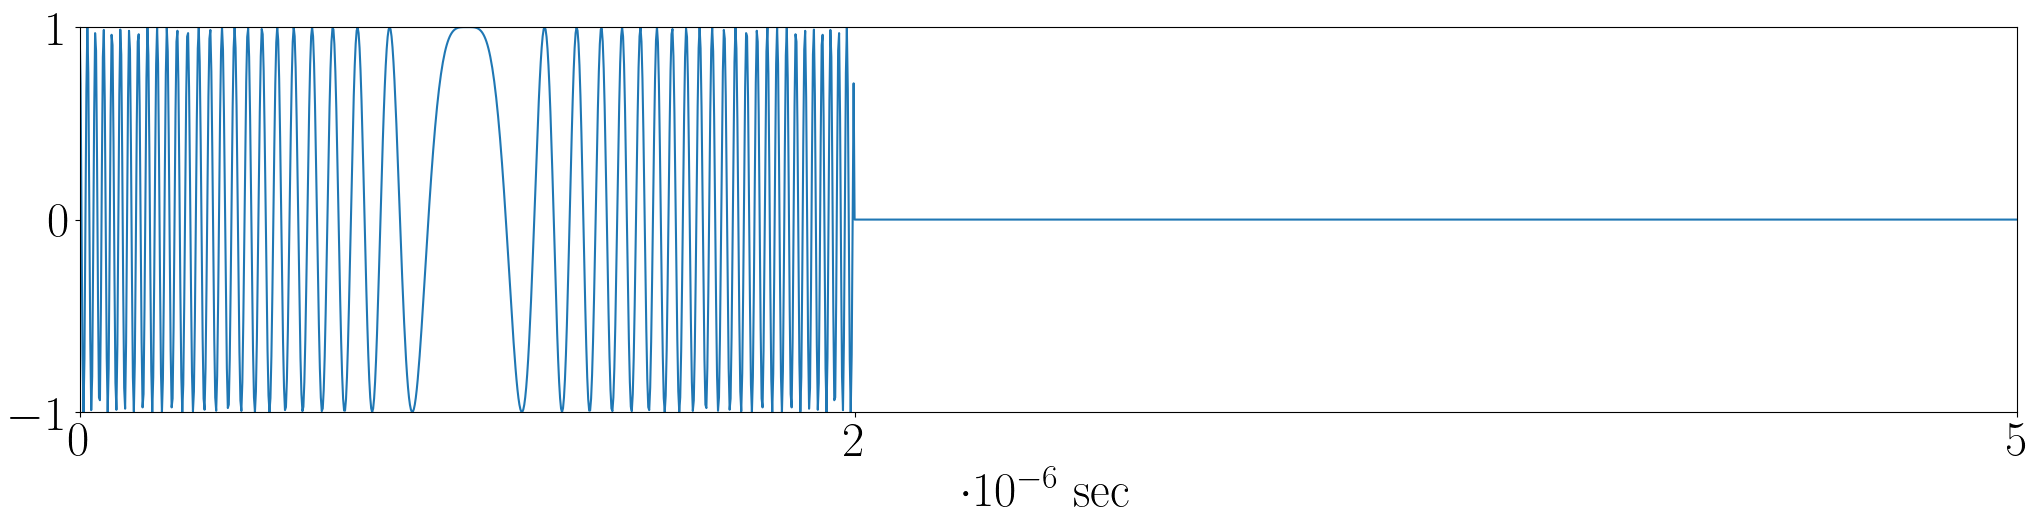

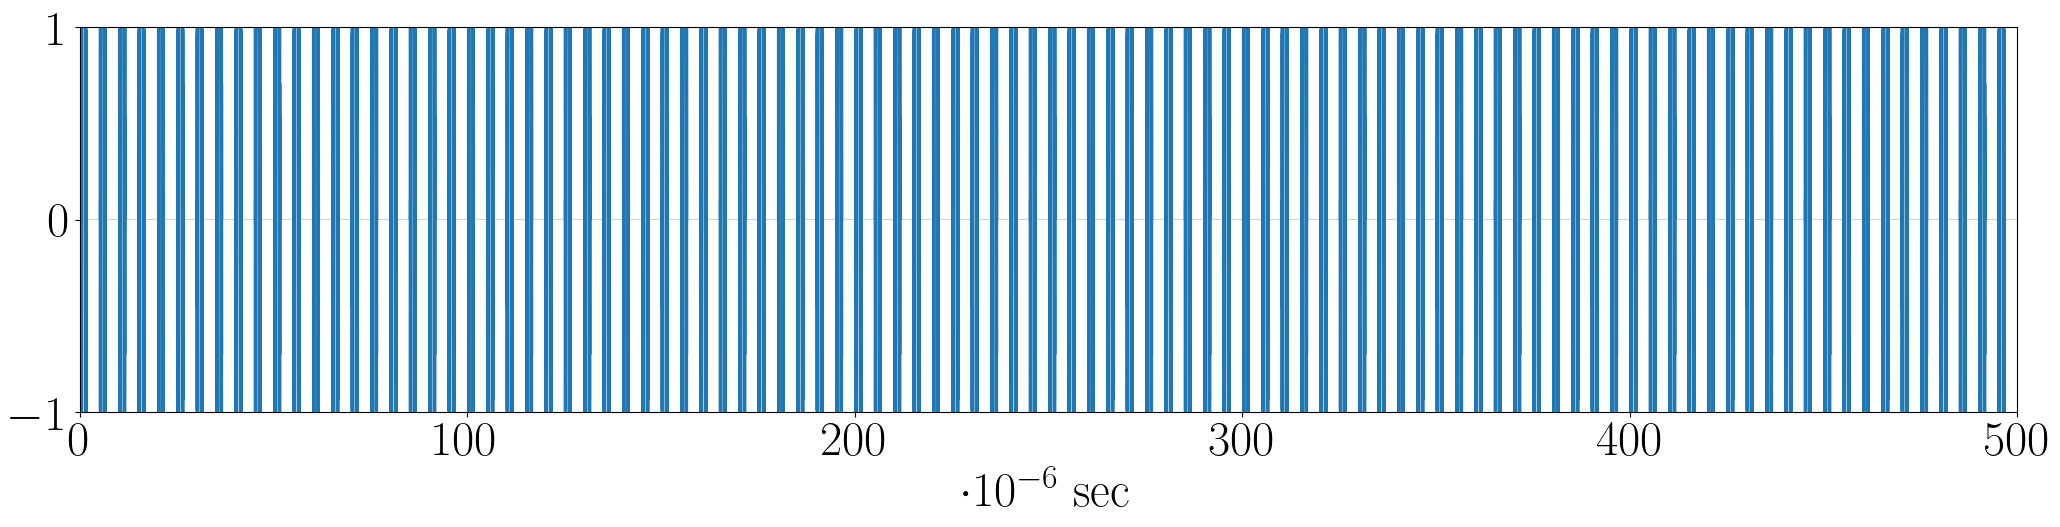

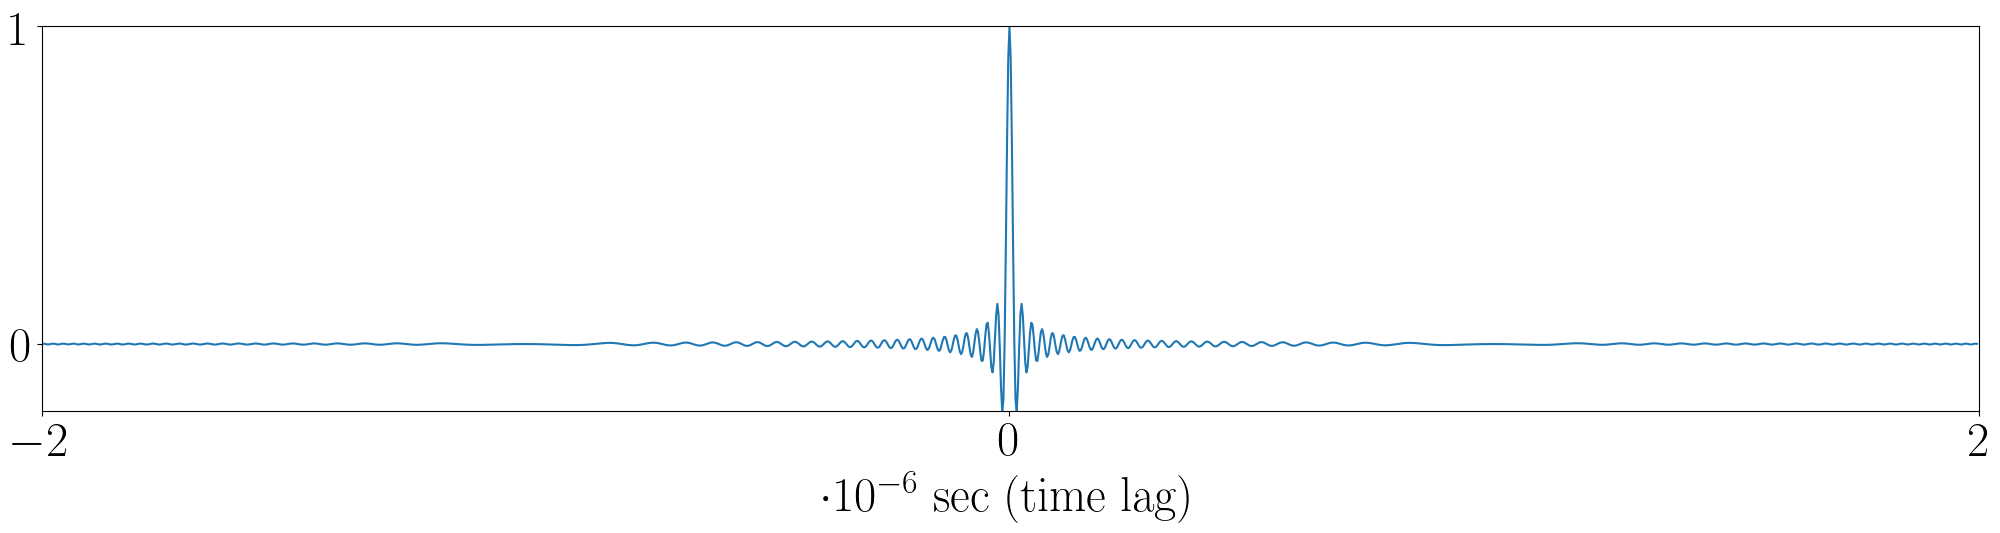

In [63]:
# Plot transmitted signal


# plot a single PRI
f = plt.figure(figsize=(25,5))
plt.plot(signal_Tx[0:idx_PRI])
plt.xlim([0, idx_PRI])
plt.ylim([-1, 1])
plt.yticks(ticks=[-1,0,1],fontsize=35)
plt.xticks(ticks=[0, idx_Tx, idx_PRI],labels=['$0$','$2$','$5$'],fontsize=35)
plt.xlabel('$\cdot 10^{-6}\ \mathrm{sec}$',fontsize=35)
plt.show()


# plot the entire CPI
f = plt.figure(figsize=(25,5))
plt.plot(signal_Tx,linewidth=0.2)
plt.xlim([0, len(signal_Tx)])
plt.ylim([-1, 1])
plt.xticks(ticks=np.linspace(0,len(signal_Tx),6),labels=['$0$','$100$','$200$','$300$','$400$','$500$'],fontsize=35)
plt.yticks(ticks=[-1,0,1],fontsize=35)
plt.xlabel('$\cdot 10^{-6}\ \mathrm{sec}$',fontsize=35)
plt.show()


# Autcorrelation of the Tx part of the chirp
f = plt.figure(figsize=(25,5))
ac = np.convolve(np.conjugate(np.flip(signal_Tx[0:idx_Tx])), signal_Tx[0:idx_Tx])
plt.plot(ac)
plt.xlim([0, 2*idx_Tx-1])
plt.xticks(ticks=[0,idx_Tx-1,2*idx_Tx],labels=['$-2$','$0$','$2$'],fontsize=35)
plt.xlabel('$\cdot 10^{-6}\ \mathrm{sec\ } \mathrm{(time\ lag)}$',fontsize=35)
plt.ylim([np.min(np.real(ac)), np.max(np.real(ac))])
plt.yticks(ticks=[0,np.max(np.real(ac))],labels=['$0$','$1$'],fontsize=35)
plt.show()

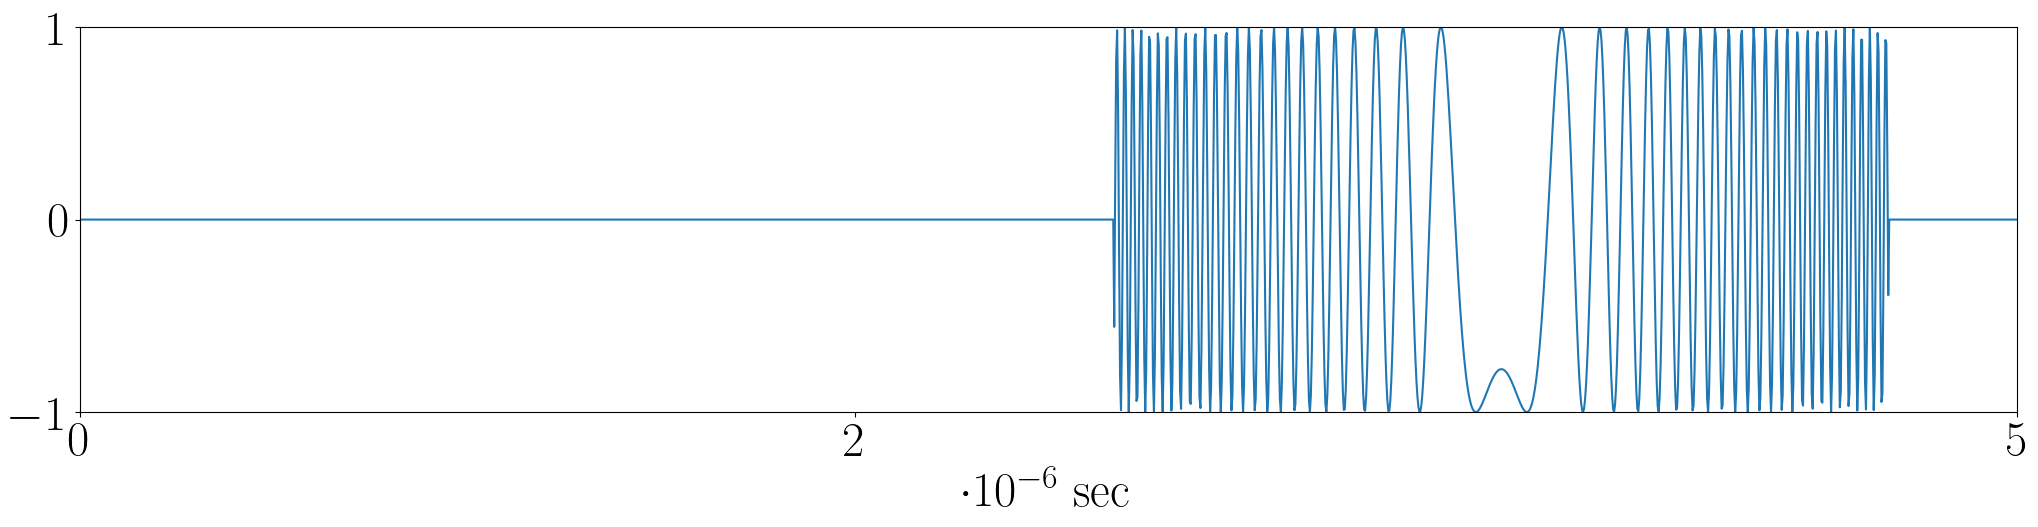

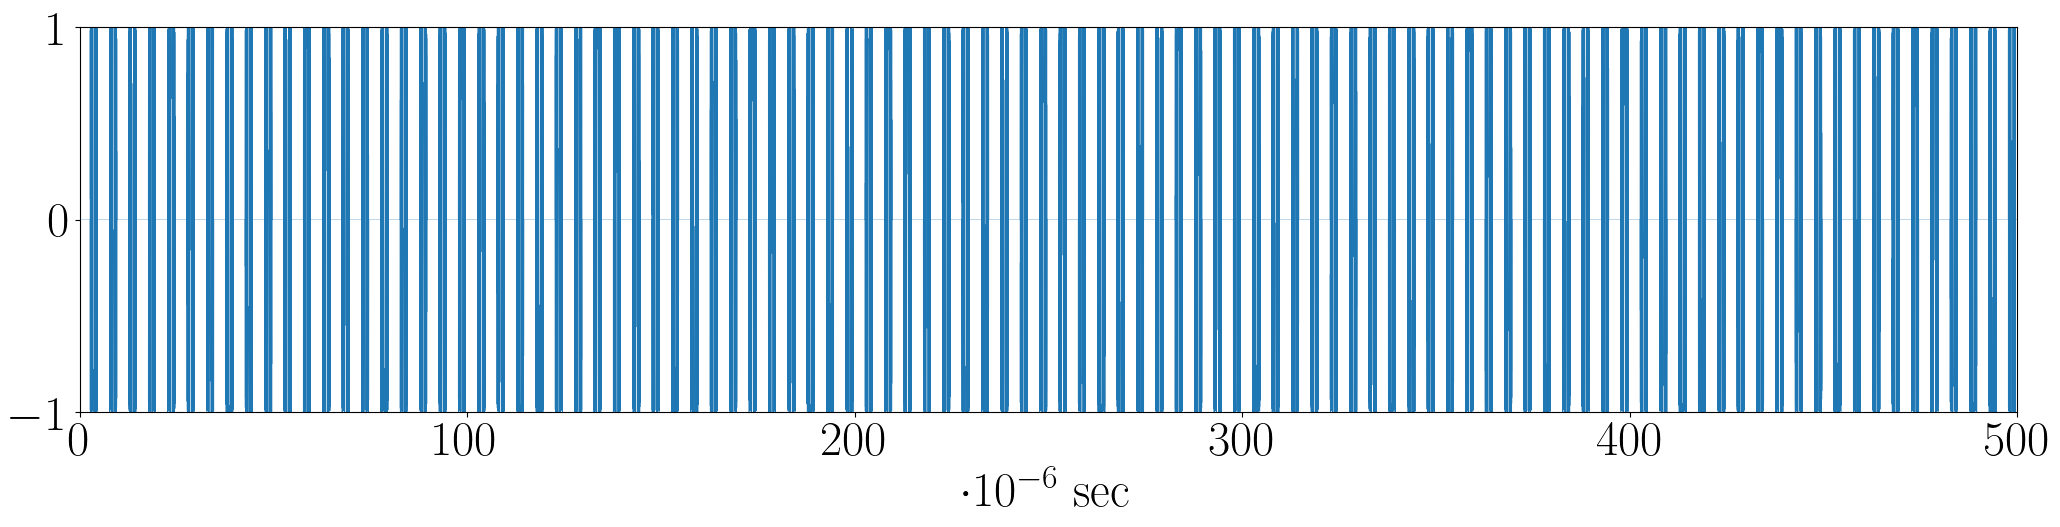

In [64]:
# Plot received signal


# plot a single PRI
f = plt.figure(figsize=(25,5))
plt.plot(signal_Rx[0:idx_PRI])
plt.xlim([0, idx_PRI])
plt.ylim([-1, 1])
plt.yticks(ticks=[-1,0,1],fontsize=35)
plt.xticks(ticks=[0, idx_Tx, idx_PRI],labels=['$0$','$2$','$5$'],fontsize=35)
plt.xlabel('$\cdot 10^{-6}\ \mathrm{sec}$',fontsize=35)


# plot the entire CPI
f = plt.figure(figsize=(25,5))
plt.plot(signal_Rx,linewidth=0.2)
plt.xlim([0, len(signal_Rx)])
plt.ylim([-1, 1])
plt.xticks(ticks=np.linspace(0,len(signal_Tx),6),labels=['$0$','$100$','$200$','$300$','$400$','$500$'],fontsize=35)
plt.yticks(ticks=[-1,0,1],fontsize=35)
plt.xlabel('$\cdot 10^{-6}\ \mathrm{sec}$',fontsize=35)
plt.show()

In [65]:
def RD_map(sRx, sTx, ncs, verbose):
    sRx_mat = 0 
    del sRx_mat  # since reshape is for view only, make sure to delete the last instance before another run
    sRx_mat = sRx[0:-1].copy()
    sRx_mat = np.reshape(sRx_mat, (N, -1))  # each row is a different PRI
    sRx_mat = sRx_mat[:,idx_Tx:idx_PRI]


    match_filter = sTx[0:idx_Tx]  # the transmitted signal (a single Pw) as match filter
    lo = np.array([np.exp(-1j*2*np.pi*fc*t) for t in time_int_CPI[idx_Tx:idx_PRI]], dtype=complex)  # local oscillator


    sRx_filtered = np.empty((N, len(match_filter)+sRx_mat.shape[1]-1), dtype = 'complex_')  # filtered signal space allocation as a complex matrix
    for i in range(N):
        sRx_filtered[i,:] = np.convolve(np.conjugate(np.flip(match_filter)), sRx_mat[i,:]*lo)


    for i in range(sRx_filtered.shape[1]):
        sRx_filtered[:,i] = np.fft.fftshift(np.fft.fft(sRx_filtered[:,i]))  # fft for each column
    

    RD_map_mat = 10*np.log10(np.abs(sRx_filtered))  # transform values to dB and create range-Doppler map
    r_scale, v_scale = (0.5*C*PRI, -C/(4*PRI*fc))  # scaling factors for transformation of axes 
    
    
    # create range-Doppler map figure  
    fig, ax = plt.subplots(1) 
    plt.imshow(RD_map_mat, aspect=RD_map_mat.shape[1]/RD_map_mat.shape[0], cmap='viridis')  # set ratio of the rectangular matrix to a square
    plt.xlim([0,idx_PRI-idx_Tx])  # set the limit of the x-axis
    plt.ylim([0,N])  # set the limit of the y-axis


    # set the default axes to range-speed axes
    xticks, yticks = (np.linspace(0, RD_map_mat.shape[1], 9), np.linspace(0, N, 9))
    ax.set(xticks=xticks, yticks=yticks)  # remove all unnecessary ticks
    xticks, yticks = (np.array(ax.get_xticks()), np.array(ax.get_yticks()))
    xtickl, ytickl = (np.linspace(0, 1, len(xticks))*r_scale, np.linspace(-1, 1, len(yticks))*v_scale)
    ax.set(xticklabels=np.int64(xtickl), yticklabels=np.int64(ytickl))  # set scaled axes labels
    plt.xlabel('Range [meters]')
    plt.ylabel('Speed [m/sec]')
    plt.title('Range-Doppler Map [dB]')
    plt.colorbar()
    plt.show()
    

    # extract the range of speed of (a single!) target from the map
    # (contrary to all other sections, currently this section can be done for only one target)
    RD_map_detect = RD_map_mat
    for i in range(L):
        max_index = np.argmax(RD_map_detect)
        rowindex, colindex = np.unravel_index(max_index, RD_map_detect.shape)
        print('Detection of target #'+str(int(i+1))+':')
        print('→ Range is', colindex*r_scale/RD_map_mat.shape[1], 'meters away')
        print('→ Speed is', (rowindex-(RD_map_mat.shape[0]/2))*v_scale/(RD_map_mat.shape[0]/2), 'meters per second\n')

        RD_map_detect[rowindex-ncs:rowindex+ncs, colindex-ncs:colindex+ncs]=0

C:\Users\eyal.gur.STAFF\AppData\Local\Temp\ipykernel_18232\2190368126.py:22: RuntimeWarning: divide by zero encountered in log10
  RD_map_mat = 10*np.log10(np.abs(sRx_filtered))  # transform values to dB and create range-Doppler map


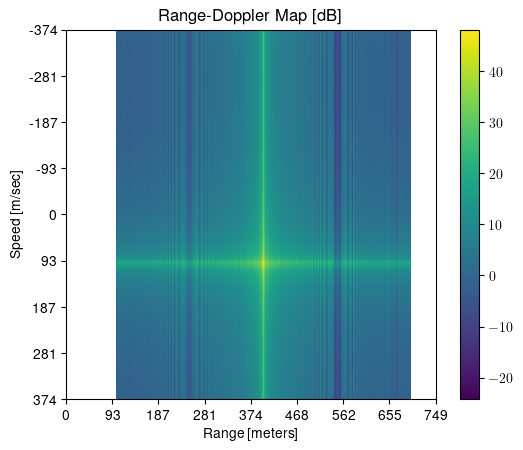

Detection of target #1:
→ Range is 400.0482149649825 meters away
→ Speed is 97.43254885 meters per second



In [66]:
# Plot range-Doppler map and detect targets
RD_map(signal_Rx, signal_Tx, ncs=5, verbose=True)

In [67]:
# wn_int = np.linspace(30,30,1)  # std of white noises in logscale
# for ss in wn_int:
#     (RD_map_mat, rscale, vscale) = RD_map(Rx(ss), signal_Tx, ncs=5, verbose=True)

#     max_index = np.argmax(RD_map_mat)
#     row_index, col_index = np.unravel_index(max_index, RD_map_mat.shape)
#     print(row_index, col_index, rscale, vscale)
#     print(np.abs((col_index*rscale/RD_map_mat.shape[1]) - R0[0]))  # return the range error
#     print(np.abs((row_index-(RD_map_mat.shape[0]/2))*vscale/(RD_map_mat.shape[0]/2) - v[0]))  # return the speed error
#prrrr = 6*(10**(-6))
#print((1/(2*prrrr)*(C/((1/prrrr)**2))))
avg_power = (1/(N*idx_Tx))*np.sum(np.real(N*signal_Tx[0:idx_Tx]))
#print(avg_power)
var_signal = (1/(N*idx_Tx-1))*np.linalg.norm(N*signal_Tx[0:idx_Tx] - avg_power)**2
var_noise = 9**2
print(np.log10(var_signal/var_noise))

#print(idx_PRI)
print(PRI)
print(C*10**(-6))
#print((C/(2*fc*CPI)))
print((C/(4*fc*PRI)))

#print((1/(N*idx_Tx))*np.sum(N*np.real(signal_Tx[0:idx_Tx])))
#print(np.linalg.norm(signal_Tx[0:idx_Tx])**2/1**2)
#print(1200*10**6/C, 1300*10**6/C)

#print(C*5*10**(-6)/2)
#print(C/(2*(5*10**(-6)*fc)))
#print(4.33/26)

#print(np.abs(400-400.0482149649824)+np.abs(100-97.43254885))
# #print(1/(10**2))
# #print(1/(2*(0.5**2)))
# #print(10*np.log10(((np.linalg.norm(sTx[0:idx_Tx]))**2)/(2*(1**2))))
# #print(10*log10(((np.linalg.norm((1/idx_Tx)*sTx[0:idx_Tx])**2)/1)))
PRF = 1/PRI
print(C*PRF/(4*fc))

print(650*2/C)

0.09149881188863636
4.9999999999999996e-06
299.792458
374.74057250000004
374.74057250000004
4.336333237575977e-06
